In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns

In [2]:
from sklearn.datasets import load_wine

raw_data = load_wine()

In [3]:
data = raw_data.data
target = raw_data.target
feature_names = raw_data.feature_names
df = pd.DataFrame(np.hstack((data, target.reshape(-1, 1))), columns=feature_names + ['target'])

In [4]:
feature_names

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

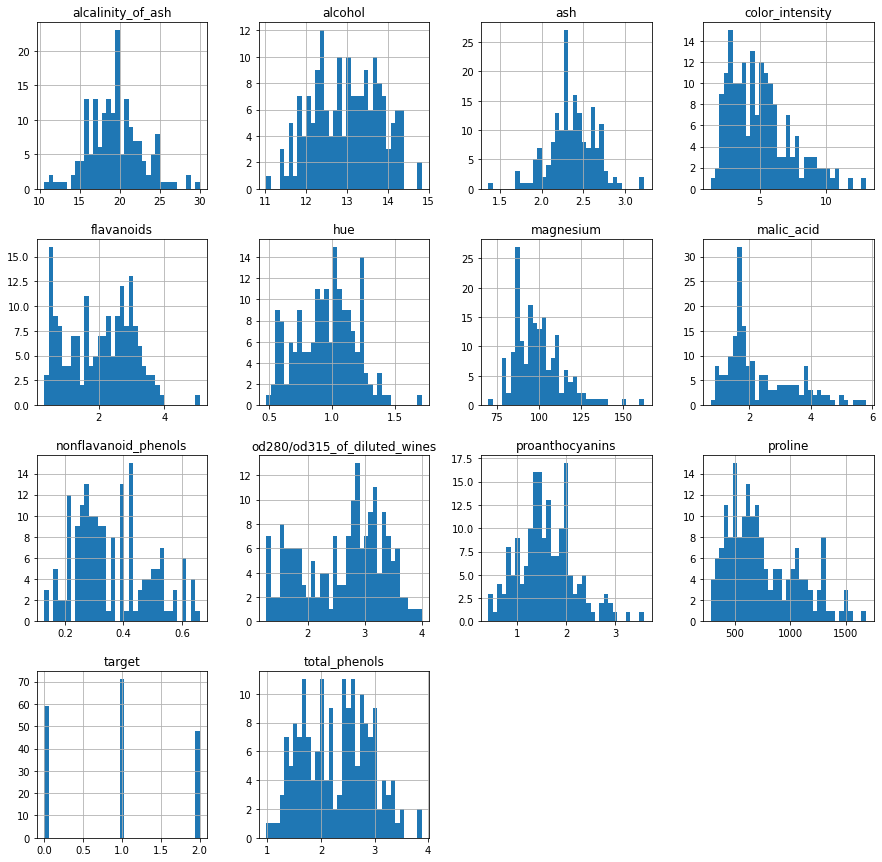

In [5]:
df.hist(bins=35, figsize=(15, 15));

Имеется датасет с 13 признаками и 3 классами. Попробуем осуществить отбор признаков для логистической регрессии.

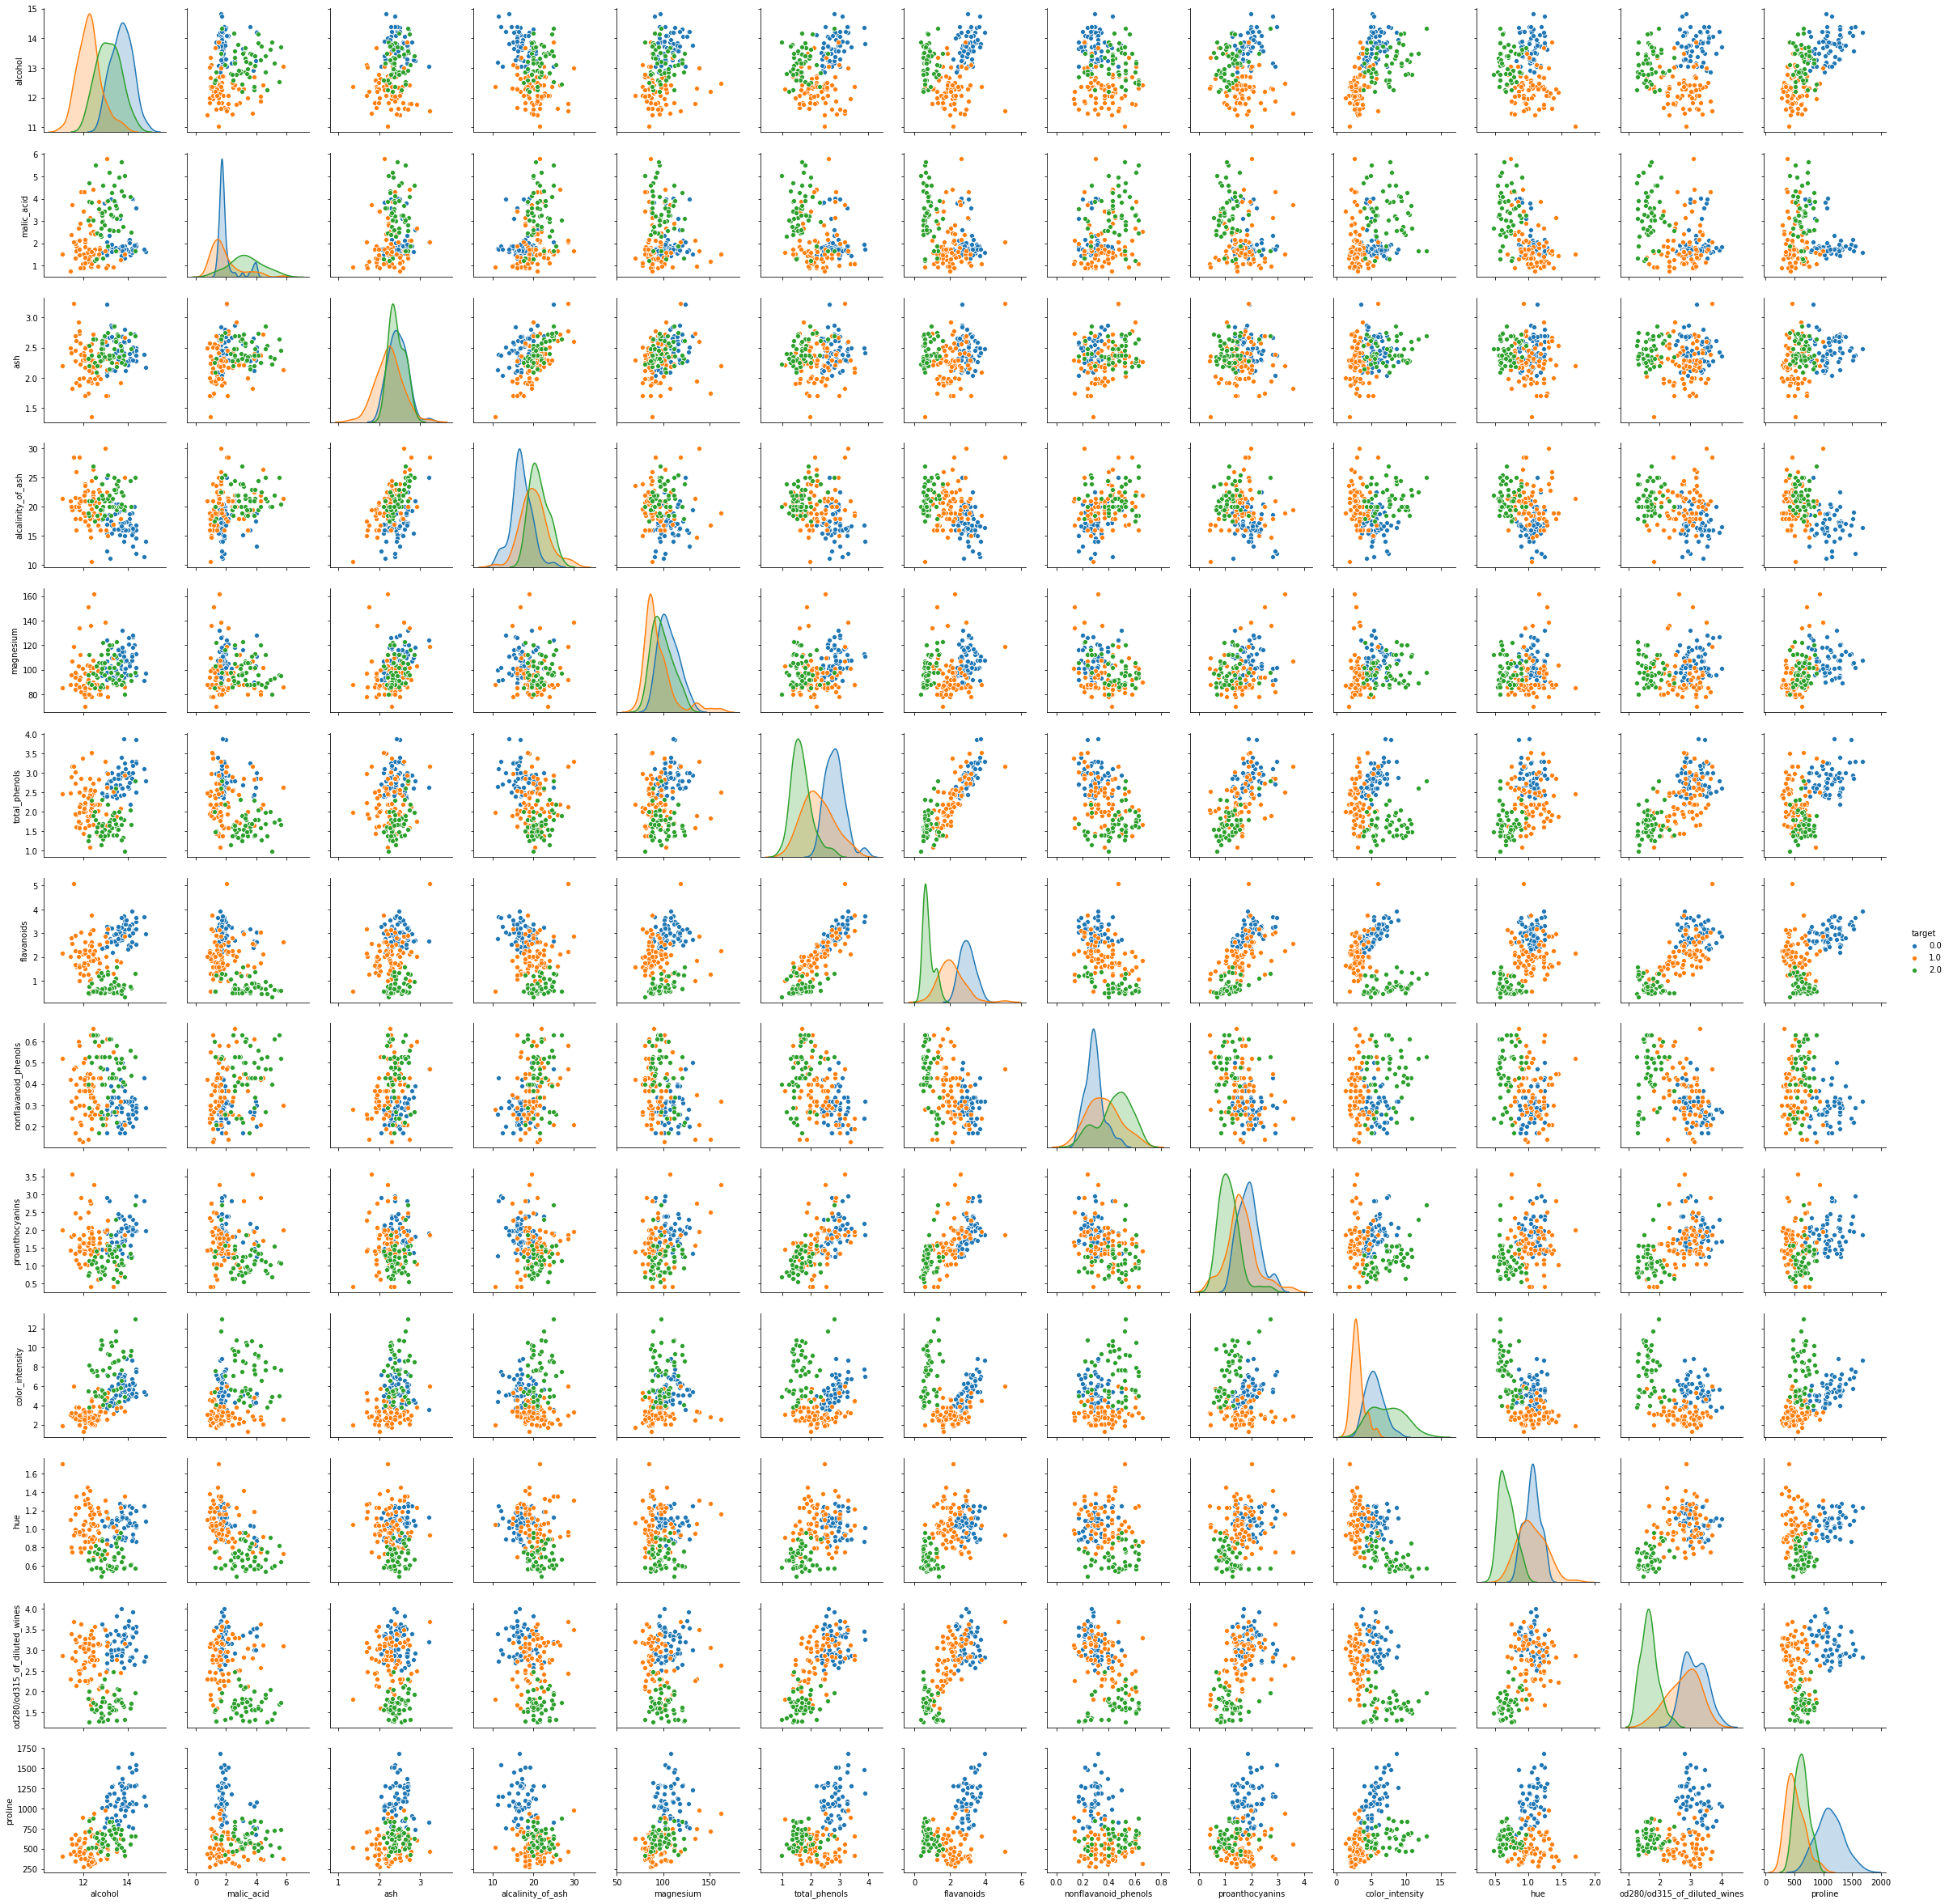

In [6]:
sns.pairplot(df, hue='target', vars=feature_names)

Уже из этих графиков можно заметить, что по некоторым парам признаков (например, alcohol и magnesium) классы можно довольно неплохо отделить линейным классификатором.

Посмотрим на взаимную линейную корелляцию самих признаков между собой.

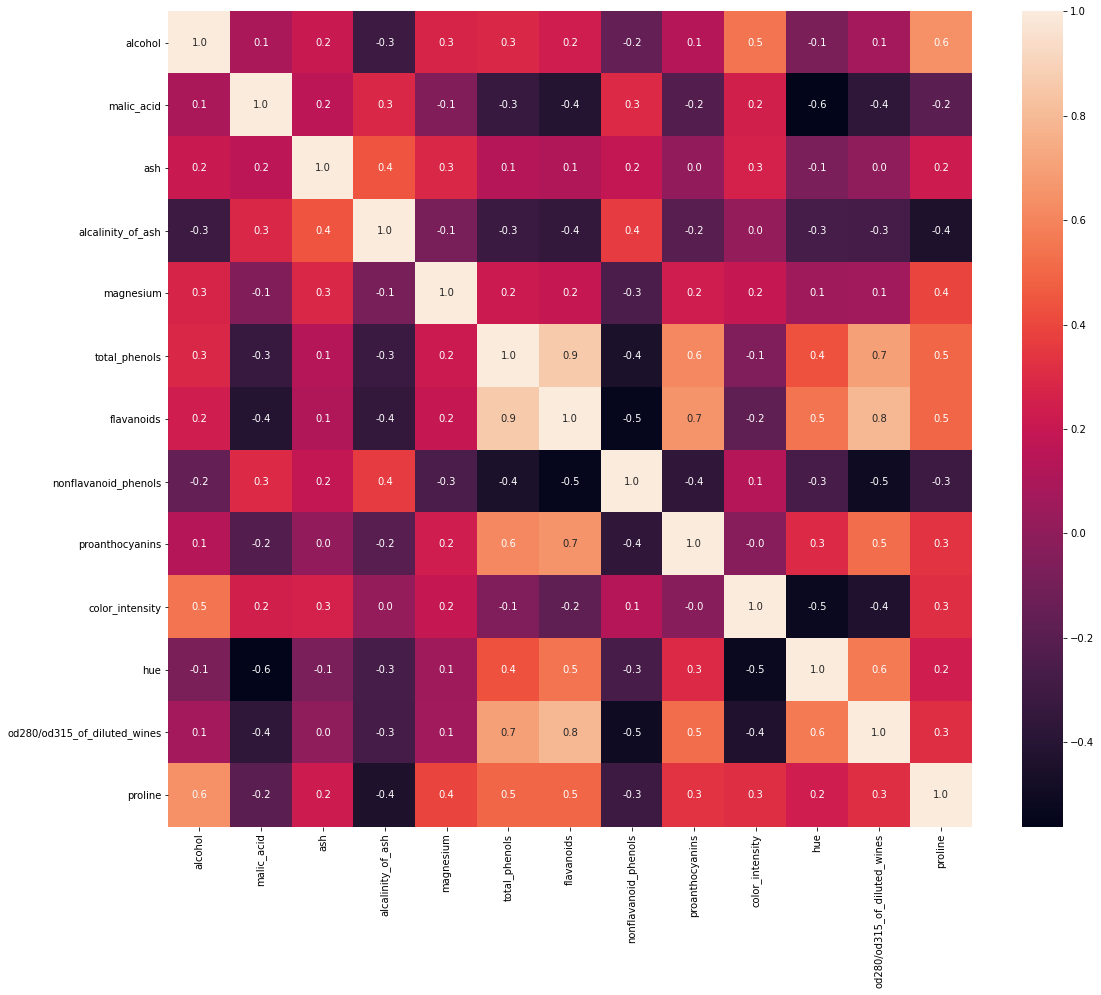

In [7]:
plt.figure(figsize=(18,15))
sns.heatmap(np.corrcoef(data.T), annot=True, xticklabels=feature_names, yticklabels=feature_names, fmt=".1f")

Некоторые признаки достаточно сильно скоррелированы между собой.

Линейную корреляцию между категориальными и вещественными признаками надо использовать с осторожностью. Однако, так как в слайдах я не нашел ничего другого подходящего для сравнивания между собой сразу нескольких признаков кроме линейной множественной корреляции, то будем использовать ее. Тут следует учесть, что таргет у нас --- это категориальная неупорядоченная величина, но численные обозначения порядок имеют. Чтобы учесть это, мы будем считать корреляцию с тремя вариантами таргета, которые получаются следующими перестановками значений исходного таргета: (0, 1, 2), (1, 2, 0) и (2, 0, 1). Остальные три перестановки получаются инвертированием одной из этих трех, поэтому корреляция в этих случаях просто сменит знак.

In [8]:
t_perm_0 = target
t_perm_1 = np.zeros_like(target)
t_perm_1[target == 0] = 1
t_perm_1[target == 1] = 2
t_perm_1[target == 2] = 0
t_perm_2 = np.zeros_like(target)
t_perm_2[target == 0] = 2
t_perm_2[target == 1] = 0
t_perm_2[target == 2] = 1

In [9]:
from itertools import chain, combinations

def powerset(iterable):
    """
        powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)
    """
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def multicorr(features, target):
    R = np.corrcoef(features.T)
    c = np.array([st.pearsonr(feat, target)[0] for feat in features.T])
    if len(c) == 1:
        return c[0]
    return np.sqrt(c @ np.linalg.inv(R) @ c)

In [10]:
from tqdm import tqdm
correlations = []

for f_names in tqdm(powerset(feature_names)):
    if len(f_names) > 0:
        features = df[list(f_names)].values
        corr_0 = multicorr(features, t_perm_0)
        corr_1 = multicorr(features, t_perm_1)
        corr_2 = multicorr(features, t_perm_2)
        correlations.append((f_names, max(corr_0, corr_1, corr_2)))

8192it [00:32, 249.51it/s]


In [11]:
corr = np.array([a[1] for a in correlations])
n_feat = np.array([len(a[0]) for a in correlations])

Text(0, 0.5, 'Множественная линейная корреляция с таргетом')

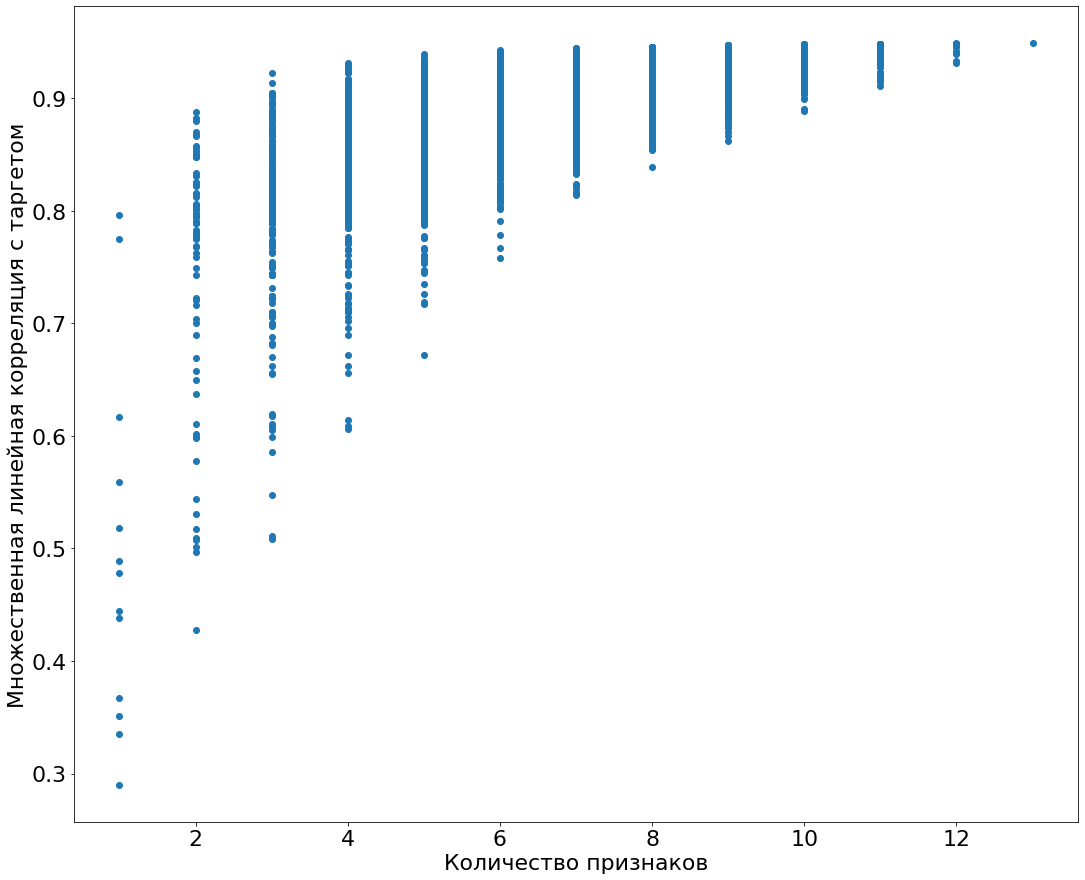

In [12]:
plt.figure(figsize=(18,15))
plt.rcParams.update({'font.size': 22})
plt.scatter(n_feat, corr)
plt.xlabel('Количество признаков')
plt.ylabel('Множественная линейная корреляция с таргетом')

Судя по картинке выше, при добавлении признаков в количестве более, чем 3, корреляция с таргетом не сильно возрастает. Попробуем обучить логистическую регрессию на трех наиболее скоррелированных с таргетом признаках. В качестве метрики качества сойдет и точность, так как классы достаточно сбалансированы.

In [38]:
_corr = corr.copy()
_corr[n_feat != 3] = 0
features = correlations[np.argmax(_corr)][0]
features

('flavanoids', 'color_intensity', 'proline')

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.values, target, 
                                                    stratify=target, test_size=0.3, random_state=42)
feature_names = np.array(feature_names)

In [40]:
from sklearn.linear_model import LogisticRegression

f_indexes = np.where(np.isin(feature_names, features))[0]
clf = LogisticRegression(max_iter=10000)
clf.fit(X_train[:, f_indexes], y_train)
print(f'Точность на отложенной выборке при обучении логистической регресии на трех отобранных признаках равна\
 {np.round(clf.score(X_test[:, f_indexes], y_test), 4)}')
print(f'Точность на трейне {np.round(clf.score(X_train[:, f_indexes], y_train), 4)}')

Точность на отложенной выборке при обучении логистической регресии на трех отобранных признаках равна 0.963
Точность на трейне 0.9516


In [41]:
clf.fit(X_train, y_train)
print(f'Точность на отложенной выборке при обучении логистической регресии на всех признаках равна\
 {np.round(clf.score(X_test, y_test), 4)}')
print(f'Точность на трейне {np.round(clf.score(X_train, y_train), 4)}')

Точность на отложенной выборке при обучении логистической регресии на всех признаках равна 0.9815
Точность на трейне 1.0


Падение качества минимально.

Ради интереса посчитаем качество на всевозможных подмножествах признаков.

In [20]:
from tqdm import tqdm
train_accuracy = []
test_accuracy = []

for f_names in tqdm(powerset(feature_names)):
    if len(f_names) > 0:
        f_indexes = np.where(np.isin(feature_names, f_names))[0]
        clf.fit(X_train[:, f_indexes], y_train)
        train_accuracy.append(clf.score(X_train[:, f_indexes], y_train))
        test_accuracy.append(clf.score(X_test[:, f_indexes], y_test))

8192it [34:36,  3.94it/s]


In [21]:
n_feat = np.array([len(a) for a in powerset(feature_names) if len(a) > 0])

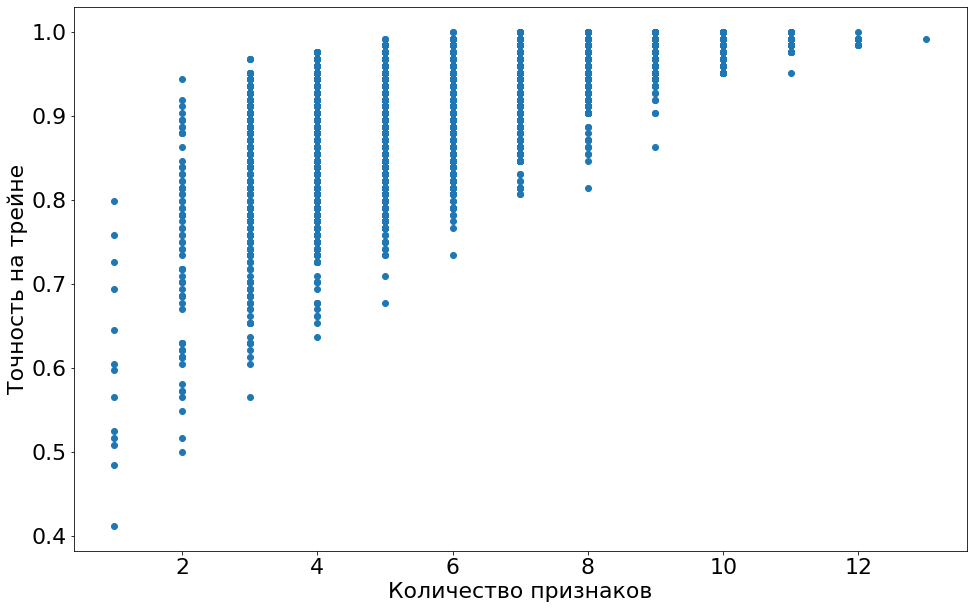

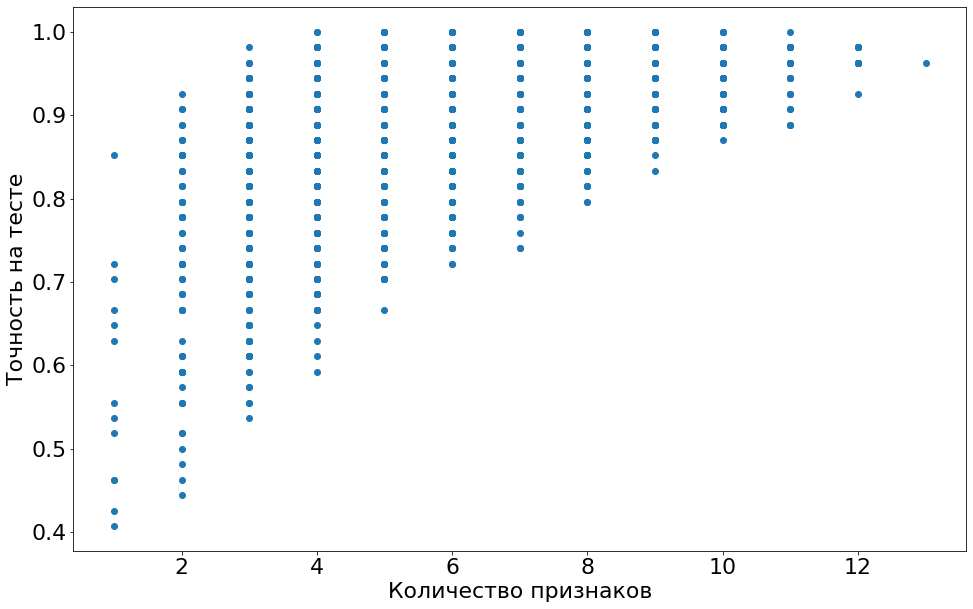

In [25]:
plt.figure(figsize=(16,10))
plt.scatter(n_feat, train_accuracy)
plt.xlabel('Количество признаков')
plt.ylabel('Точность на трейне')
plt.show()
plt.figure(figsize=(16,10))
plt.scatter(n_feat, test_accuracy)
plt.xlabel('Количество признаков')
plt.ylabel('Точность на тесте')
plt.show()

Проверим, что на наилучшее качество на тестах достигается на тех же трех признаках

In [26]:
_test_acc = test_accuracy.copy()
_corr[n_feat != 3] = 0
correlations[np.argmax(_corr)][0]

('flavanoids', 'color_intensity', 'proline')

Конечно, на последней картинке можно увидеть, что качество на тесте выходит на плато на 4х признаках, а не на 3х, но все-таки признаки отбирались по другому критерию, да и на 3х качество вполне сносное =)